## Tutorial 2: Poisson Equation

In this tutorial, a set of equations will be developed to solve the Poisson equation $\Delta p = f$ using Jacobi as the linear solver, where $\Delta$ denotes the Laplace operator. The main objective is to apply the concepts presented in the previous tutorial to generate explicit equations that represent the application of an implicit method.

__Note 0__: If you want to check the interactive plots, do not try to use the notebook command "Restart and Run All Cells". For some reason, "%matplotlib" cells sometimes do not work correctly if you do that and the plots might not work as expected. If you want to restart the page, either use "Restart kernel and clear output" or reload the notebook.

The specialization of the Poisson equation for the two dimensional case is as follows:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = f(x, y)$$

We will use Dirichlet boundary conditions $p = 0$ on all boundaries and the equation will be driven by the forcing term $f$ such that the solution is known and equal to $p(x, y) = \sin{(2 \pi x)} (1 - \cos{(2 \pi y)})$. Note that it respects the boundary condition when the grid is defined in the domain $[0, 1] \times [0, 1]$.

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = f(x, y) \implies
f(x, y) = -4 \pi^2 (1 - \cos{(2 \pi y)}) \sin{(2 \pi x)} + 4 \pi^2 \sin{(2 \pi x)} \cos{(2 \pi y)} =
4 \pi^2 \sin{(2 \pi x)} (2 \cos{(2 \pi y)} - 1)$$

__Note 1__: The solution is pre-set so that it can be further used as a reference to calculate the absolute and relative errors of the approximated solution obtained by the implicit methods.

First, the __Grid__ is defined, which will contain the numerical values for $p$ in the domain, and also the __TimeFunction__, which is the symbolic representation of the variable $p$ inside Devito. Even though the Poisson equation does not depend on a time dimension, we use time to represent the passage of the iterations of the implicit method.

__Note 2__: We will store the values of $p$ for all iterations by using the parameter "save" when creating the __TimeFunction__. This is very inefficient, but is necessary to make further analysis on how the solution is evolving after each iteration.

__Note 3__: It is possible to avoid using the class __TimeFunction__, which has some properties specific to problems that actually have a time dimension. This can be avoided by creating a __Dimension__ of iteration and replacing $p$ to be a __Function__. This is not recomended though, since the __TimeFunction__ class has some nice implementations on alternating buffers if you do not want to save all iterations.

In [1]:
from devito import Grid, TimeFunction, Function, Dimension

shape = (50, 50)   # Grid size in number of points
extent = (1., 1.)  # Grid domain limits -> [0,1] x [0,1]

space_order = 2 # The spatial order when discretizing the PDE

nmax = 2000 # Maximum number of iterations of the implicit solver

grid = Grid(shape = shape, extent = extent) # The spatial grid

# The symbolic representation of the Poisson function
p = TimeFunction(name = 'p', grid = grid, space_order = space_order, save = nmax + 2)

We will now define the forcing term $f$ as a __Function__, since it is constant over all iterations. We also define the dimensions of the problem, namely $x$ and $y$ as the spatial dimensions and $t$ as the dimension of iteration. The initial condition is set to be random at each point, which will further show some of the properties of the Jacobi method.

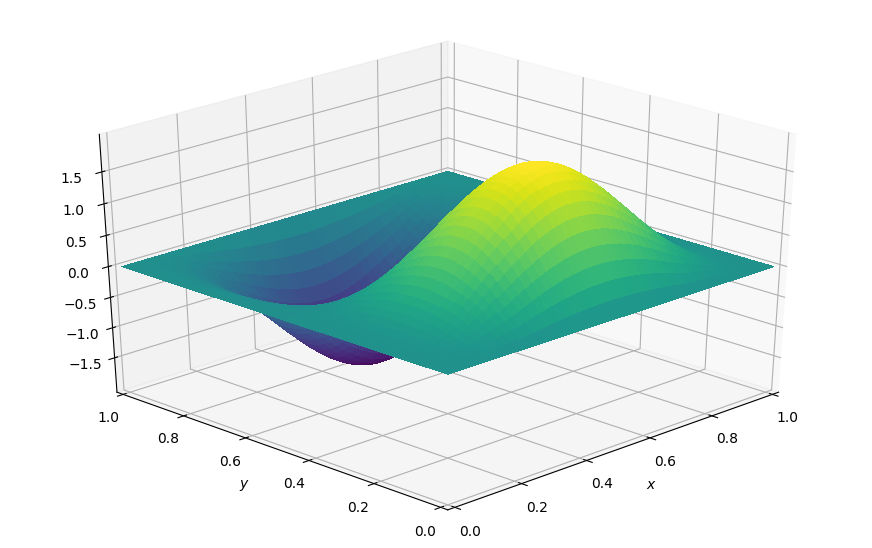

In [2]:
from devito import Function
from examples.cfd import plot_field
from numpy import pi, sin, cos, arange, meshgrid, linspace
from numpy.random import rand

# The symbolic representation of the Poisson source/forcing term
f = Function(name = 'f', grid = grid, space_order = space_order)

# The x and y variables represent the spatial dimensions in p(x, y)
x, y = grid.dimensions

# The dimension of iteration
# p(n = 0) is the initial condition, p(n = 1) is the result after one iteration
n = p.time_dim

# The initial condition is randomized between [-2, 2] = 4 * [0, 1] - 2
p.data[0, :, :] = 4 * rand(shape[0], shape[1]) - 2

# Calculate the values for the forcing term and the expected solution
X, Y = meshgrid(linspace(0., 1., shape[0], endpoint = True), linspace(0., 1., shape[1], endpoint = True),
                sparse = True)
f.data[:] = 4 * pi ** 2 * sin(2 * pi * X) * (2 * cos(2 * pi * Y) - 1)
solution = sin(2 * pi * X) * (1 - cos(2 * pi * Y))

plot_field(solution, xmax = 1., ymax = 1., view = (30, 225))

The figure above is a plot of the expected solution. We can now create the representation of the PDE inside devito.

In [3]:
from devito import Eq

pde = Eq(p.laplace, f, subdomain = grid.interior)

print("%s = %s" % (pde.lhs.evaluate, pde.rhs.evaluate))

-2.0*p(time, x, y)/h_y**2 + p(time, x, y - h_y)/h_y**2 + p(time, x, y + h_y)/h_y**2 - 2.0*p(time, x, y)/h_x**2 + p(time, x - h_x, y)/h_x**2 + p(time, x + h_x, y)/h_x**2 = f(x, y)


When using an iterative algorithm, it is useful to establish a stopping criteria, so that not all the iterations have to be executed. In this tutorial, we use the criteria of the euclidian norm between the difference of two consecutive iterations is less than a limit $\epsilon$:

$$\mathrm{stop\ if\ } ||p_{n+1}-p_n||_2 < \epsilon$$

To implement the stopping criteria, we need to define a variable to represent the norm of the difference between two iterations, which will be further compared with $\epsilon$ to check for the need to halt the execution of the iterations. Since the residual must be calculated after one full execution of an iteration, two temporary dimensions "xtemp" and "ytemp" must be created so that devito does not put both the residual calculation and the PDE equation in the same loop.

An auxiliary variable "niter" will also be used to store the value of the current iteration so that we can check how many iterations were executed.

__Note 4__: To represent a scalar ("residual" and "niter"), we must create a __Function__ which has a singular shape, in other words, it is seen by devito as an array with only one element. Therefore, we must specify a dimension for the array, even though there is actually no possible values for this dimension other than 0.

In [4]:
from devito import DefaultDimension, ConditionalDimension
from numpy import int32

# Temporary dimensions used to separate the residual calculation from the PDE equation
# Note: The default value is passed so that devito knows what are the upper bounds for this dimension
xtemp = DefaultDimension(name = 'xt', default_value = p.shape[1] - 1)
ytemp = DefaultDimension(name = 'yt', default_value = p.shape[2] - 1)

xy_to_xtyt = [(x, xtemp), (y, ytemp)] # Used to convert an equation written in (x,y) to (xtemp, ytemp)

# The minimum residual to stop iterating (residual goal)
# Note: The Jacobi method converges slowly for this problem, choose a high enough epsilon
epsilon = 0.1

# The norm of the residuals to be compared with epsilon
residual = Function(name = 'residual', shape = (1,), dimensions = (Dimension(name = 'residual_dim'),))
residual.data[0] = 0

cn = ConditionalDimension(name = 'cn', parent = n, condition = (residual[0] >= epsilon), brk = True)

# The variable that will store which iteration we are currently executing
niter = Function(name = 'niter', shape = (1,), dimensions = (Dimension(name = 'niter_dim'),),
                 dtype = int32)

Finally we will define each of the equations to be passed to devito:

1. __Implicit Method Equation__ (iterEq): This is the equation of one iteration of the implicit method (Jacobi) applied to the partial differential equation $p_{n+1} = F(p_n)$. In this case, the Jacobi method consists of isolating the term p(x, y) from the discretized PDE and applying the resulting equation to each grid point.

2. __Residual Equation__ (resEq): This is the equation that calculates the residual after an iteration. It can be calculated as the norm of the difference between the previous and the current iterations.

3. __Iteration Counter Equation__ (cntEq): This equation is used to save the value of the current iteration so that we can know what was the last executed iteration. An alternative would be to pre-set the values of p.data[1:] to zero and then check for the first unmodified iteration, in which everything would still be  zero.

4. __Boundary Condition Equations__ (boundary): This are the equations for the Dirichlet boundary condition $p(x, 0) = p(x, 1) = p(0, y) = p(1, y) = 0$.

In [5]:
from devito import solve, Inc
from sympy import symbols

a, b = symbols('a b') # Sympy symbols used to represent generic variables

iterEq = Eq(p.forward, solve(pde, p))

# Note: 'implicit_dims = [n]' is used to make the equation residual = 0 be dependent on the iteration dimension.
# This is necessary so devito puts this equation inside the iteration loop
resEq = [Eq(residual[0], 0, implicit_dims = [n]),
         Inc(residual[0], (p.forward - p).evaluate.subs(xy_to_xtyt) ** 2)]

# The conditional dimension 'cn' is used so that the stop criteria check is made when executing this equation
cntEq = Eq(niter[0], cn)

boundary = [Eq(p[n + 1, 0, y], 0.)]
boundary += [Eq(p[n + 1, x.symbolic_max, y], 0.)]
boundary += [Eq(p[n + 1, x, 0], 0.)]
boundary += [Eq(p[n + 1, x, y.symbolic_max], 0.)]

eqs = [iterEq] + boundary + resEq + [cntEq]

The final step is to create and run the Operator responsible for solving the PDE. After that the final result can be plotted.

Operator `Kernel` run in 0.01 s


Executed 418 iterations to finally get a residual of 9.958871e-02


<IPython.core.display.Javascript object>


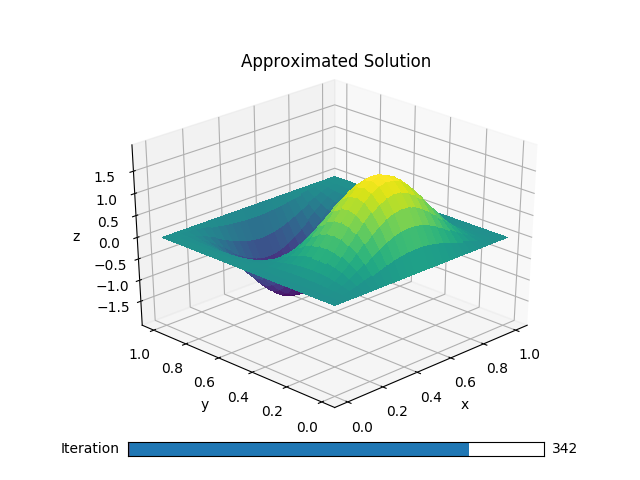

In [6]:
%matplotlib notebook
from devito import Operator, configuration
from examples.implicit import plot_iterative

# The loop-splitting needs to be disabled since the operator will have a single iteration loop
configuration["loop-splitting"] = False

op = Operator(eqs) # Create the operator

op(time_M = nmax) # Run the operator

last_iter = niter.data[0] + 1 # +1 since the residual check happens AFTER one iteration

if last_iter == nmax:
    print("Failed to converge after %d iterations" % nmax)
else:
    print("Executed %d iterations to finally get a residual of %e" % (last_iter, residual.data[0]))

plot_iterative(p.data[0:last_iter], view = (30, 225), title = "Approximated Solution")

As you can see by moving the iteration slider on the figure above, the Jacobi method is best when used to eliminate high frequencies in the solution. After only some initial iterations, the "noise" that was randomly generated already gets the basic form of the solution. Most of the iterations are then used to perfect the solution by slowly solving for the low frequencies. That is why the Jacobi and SOR methods are often used as pre-conditioners for other implicit methods.

Let's now plot the evolution of the residual and then plot the absolute error in each iteration.

The last manually calculated residual 0.100166 should be approximately equal to the last devito residual 0.099589
Maximum error at the last iteration is 1.897428e-01 and happens at (x, y) = [0.46938775 0.75510203]


<IPython.core.display.Javascript object>


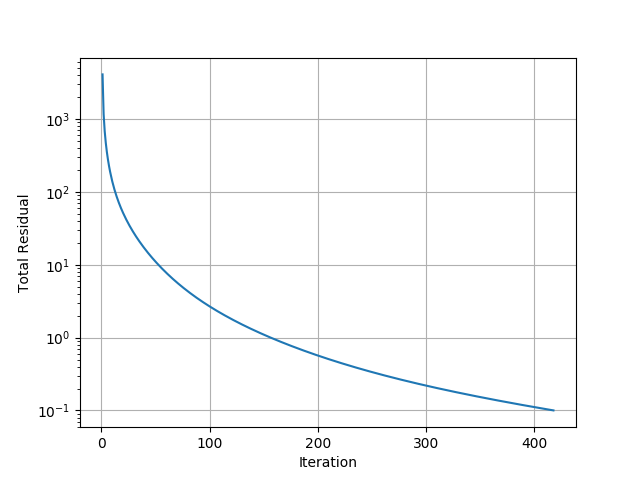

<IPython.core.display.Javascript object>


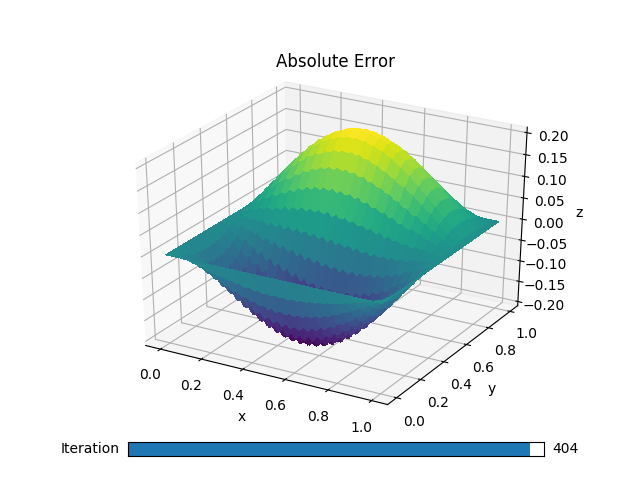

In [7]:
import matplotlib.pyplot as plt
from numpy import sum, argmax, unravel_index, array

# Calculate the residual and absolute error at each grid point
I = arange(1, last_iter + 1)
resid = p.data[I, :, :] - p.data[I - 1, :, :]
error = p.data[0:last_iter + 1, :, :] - solution

# Calculate the total residual for each step
total_resid = []
for i in range(resid.shape[0]):
    total_resid.append(sum(resid[i, :, :] ** 2))
    
print("The last manually calculated residual %f should be approximately equal to the last devito residual %f" % 
      (total_resid[-1], residual.data[0]))

last_error = error[last_iter, :, :]
max_error_idx = unravel_index(argmax(last_error), last_error.shape)
print("Maximum error at the last iteration is %e and happens at (x, y) = %s" %
      (last_error[max_error_idx], max_error_idx * array(grid.spacing[0], grid.spacing[1])))

# Plot the total residual
plt.figure()
plt.grid()
plt.xlabel("Iteration")
plt.ylabel("Total Residual")
plt.yscale('log')
plt.plot(I, total_resid)

# Plot the absolute error at each grid point
plot_iterative(error, dynamic = True, title = "Absolute Error")